In [1]:
import os
os.chdir("E:\\Projects\\diffusion")
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import warnings
from tqdm.auto import tqdm
import numpy as np
from diffusers.utils import randn_tensor
from stadiff.models import SpaUNet1DModel
from stadiff.pipeline import prepare_dataset
import torch.nn.functional as F
from diffusers import DDPMScheduler
from collections import defaultdict
from torch_geometric.loader import NeighborLoader
from diffusers.models.unet_1d import UNet1DModel
from stadiff.analytics import mclust_R
from stadiff import utils
os.environ["R_HOME"] = r"D:\Program Files\R\R-4.0.3"

warnings.filterwarnings("ignore")
sns.set_theme("paper", style="ticks", font_scale=1.25)

def evaluate(adata, data, niose_scheduler, model, save_folder=None,
             prefix=None,
             cluster_method="mclust",
             cluster_params=7):
    denoised = randn_tensor(data.x.shape, device=data.x.device)
    denoised = denoised.unsqueeze(1)
    with torch.no_grad():
        for t in niose_scheduler.timesteps:
            if isinstance(model, UNet1DModel):
                model_output = model(denoised, t).sample
            elif isinstance(model, SpaUNet1DModel):
                model_output = model(denoised, t, data.spatial).sample
            else:
                raise NotImplementedError
            denoised = niose_scheduler.step(model_output, t, denoised).prev_sample
    denoised = denoised.squeeze(1)
    adata.obsm["STAGATE_denoised"] = denoised.cpu().numpy()
    sc.pp.neighbors(adata, use_rep="STAGATE_denoised", n_neighbors=30)
    sc.tl.umap(adata, min_dist=0.5)
    # perform leiden clustering
    if cluster_method == "leiden":
        sc.tl.leiden(adata, key_added="leiden", resolution=cluster_params)
    elif cluster_method == "mclust":
        adata = mclust_R(adata, cluster_params,
                               use_rep="STAGATE_denoised", add_key="mclust", random_seed=2023)
    else:
        raise NotImplementedError
    if save_folder is not None:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
    with plt.rc_context():
        sc.pl.umap(adata, color=[cluster_method], ncols=1, frameon=False, wspace=0.4, use_raw=False,
                   show=False)
        plt.savefig(os.path.join(save_folder, "umap-{}_{}.png".format(prefix, cluster_method)))

def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_loop(train_loader, model, n_epochs=1000, gradient_clip=5,
               save_dir=None, model_name="model.pth"):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    loss_list = []
    pbar = tqdm(range(n_epochs))
    model.train()
    for epoch in range(1, n_epochs+1):
        for batch in train_loader:
            optimizer.zero_grad()
            z, out = model(batch.x, batch.edge_index)
            loss = F.mse_loss(out, batch.x)
            loss_list.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            optimizer.step()
            pbar.set_description(f"Epoch: {epoch}, Loss: {loss.item():.4f}")
            loss_list.append(loss.item())
        scheduler.step()
        pbar.update(1)
    # check if save_dir is not None and exists
    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        torch.save(model.state_dict(), os.path.join(save_dir, model_name))
    return model, loss_list


def eval_model(model, data, adata, add_key, num_cluster=7):
    model.eval()
    with torch.no_grad():
        z, out = model(data.x, data.edge_index)
    adata.obsm[add_key] = z.detach().cpu().numpy()
    adata = mclust_R(adata, num_cluster, use_rep=add_key, add_key=add_key + "_mclust", random_seed=2023)
    sc.pp.neighbors(adata, use_rep=add_key, n_neighbors=30)
    sc.tl.umap(adata, min_dist=0.5)
    sc.pl.umap(adata, color=[add_key + "_mclust"], ncols=1, frameon=False, wspace=0.4, use_raw=False)

device = "cuda:0"

In [2]:
adata = sc.read_h5ad("E:\Projects\diffusion\dataset\STAGATE.h5ad")

## Train auto-encoder

In [3]:
from stadiff.vae import SpaAE
from stadiff.dataset import MaskNode
data = prepare_dataset(adata, use_rep=None,
                       factor=125,
                       use_spatial='spatial',
                       use_net="Spatial_Net",
                       device=device)
loader = NeighborLoader(data, num_neighbors=[5, 3],
                        batch_size=64,
                        )
save_dir = "E:\Projects\\diffusion\\output\\Single-slice-DLPFC-raw"
n_epochs, gradient_clip = 1000, 5
spa_ae = SpaAE(input_dim=3000,
               block_list=["ResBlock"],
               gat_dim=[512, 32],
               block_out_dims=[32, 32]).to(device)
spa_ae, loss_list = train_loop(loader,
                               spa_ae,
                               n_epochs=n_epochs,
                               gradient_clip=gradient_clip,
                               save_dir=os.path.join(save_dir, "spa_ae.pth"))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
adata

AnnData object with n_obs × n_vars = 4226 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'Manual annotation', 'n_genes', 'spa_ae_mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Manual annotation_colors', 'Spatial_Net', 'hvg', 'log1p', 'neighbors', 'padding_info', 'spatial', 'umap', 'spa_ae_mclust_colors'
    obsm: 'STAGATE', 'X_umap', 'spatial', 'spatial_ind', 'spa_ae'
    obsp: 'connectivities', 'distances'

In [20]:
adata = mclust_R(adata, 7, use_rep="spa_ae", add_key="mclust", random_seed=2005, modelNames="EEE")
## Train denoise network

fitting ...
  |======================================================================| 100%


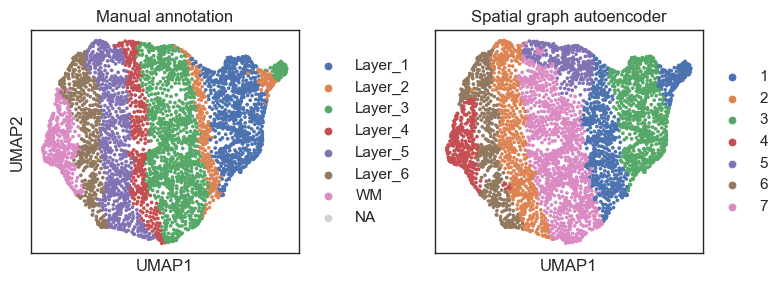

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
sc.pl.umap(adata, color=["Manual annotation"], show=False, ax=ax[0])
sc.pl.umap(adata, color=["mclust"], show=False, ax=ax[1])
ax[1].set_title("Spatial graph autoencoder")
ax[1].set_ylabel("")
plt.tight_layout()

In [40]:
# compute ari
from sklearn.metrics import adjusted_rand_score
# remove nan
ground_truth = adata.obs["Manual annotation"].dropna().values
ari = adjusted_rand_score(ground_truth, adata.obs["mclust"][~adata.obs["Manual annotation"].isna()])
print("ARI: {:.4f}".format(ari))

ARI: 0.5187


## Train denoise network

In [42]:
from stadiff.utils import MinMaxNormalize
normalizer = MinMaxNormalize(adata.obsm["spa_ae"], dim=0)
normalized_rep = normalizer.normalize(adata.obsm["spa_ae"])
adata.obsm["n_spa_ae"] = normalized_rep
data = prepare_dataset(adata, use_rep="n_spa_ae", factor=125, use_spatial='spatial',
                       use_net="Spatial_Net").to(device)
loader = NeighborLoader(data, num_neighbors=[5, 3],
                        batch_size=64,)

  0%|          | 0/1000 [00:00<?, ?it/s]

fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |=================================================================

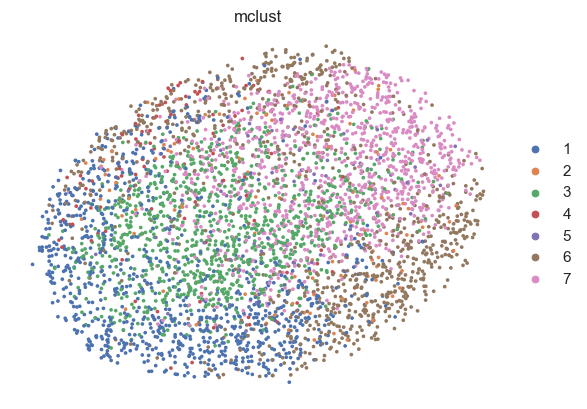

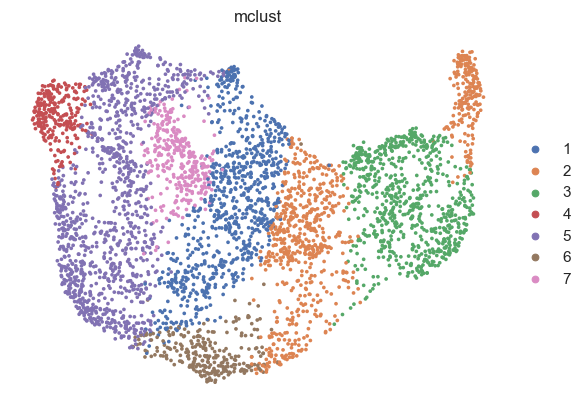

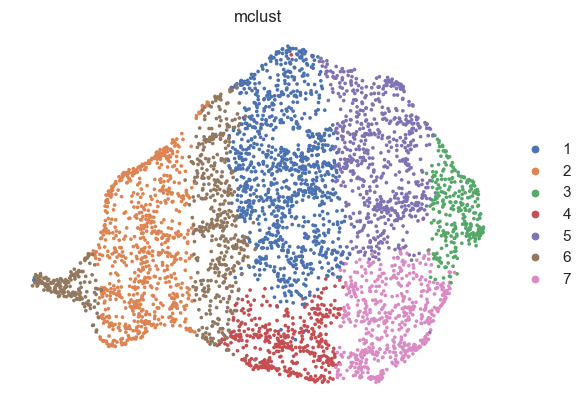

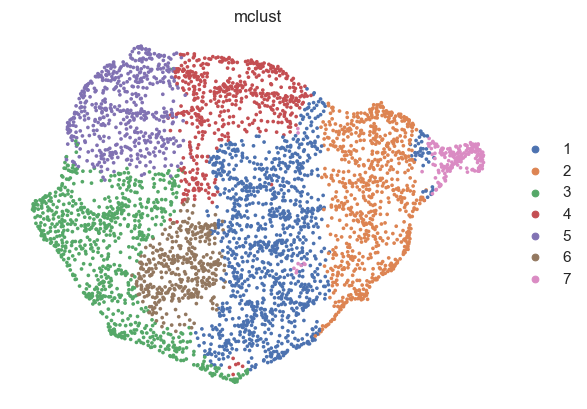

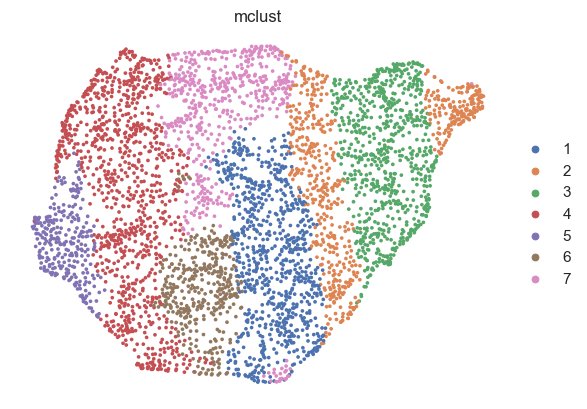

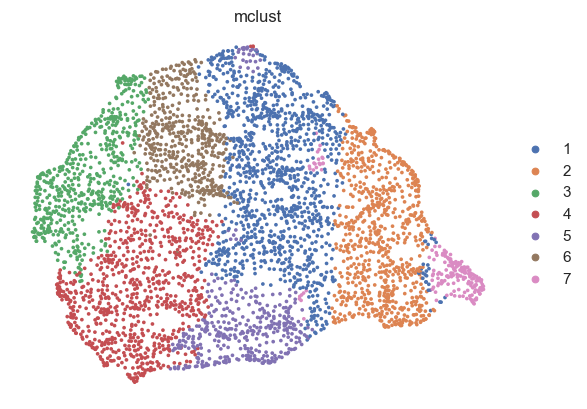

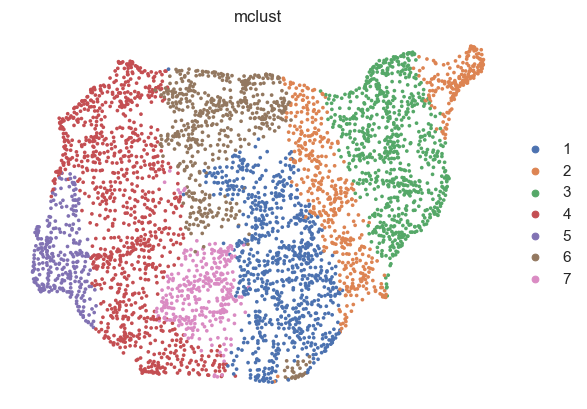

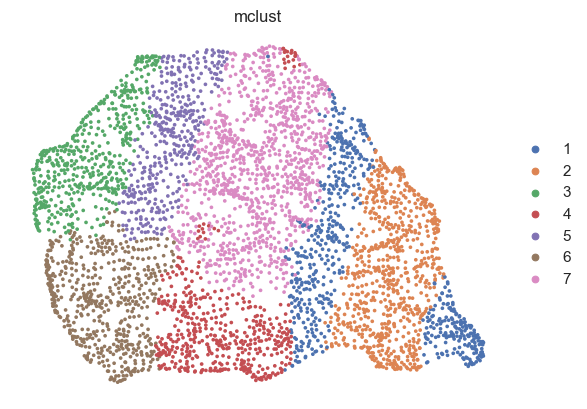

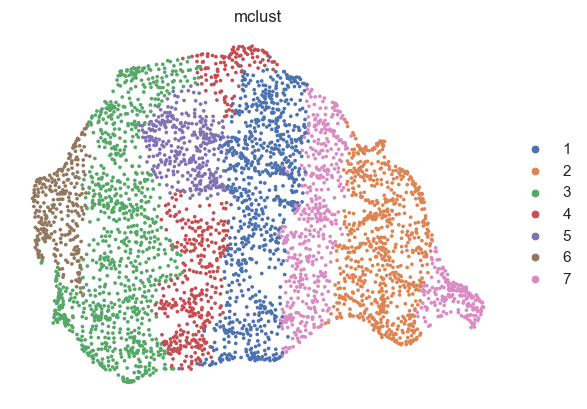

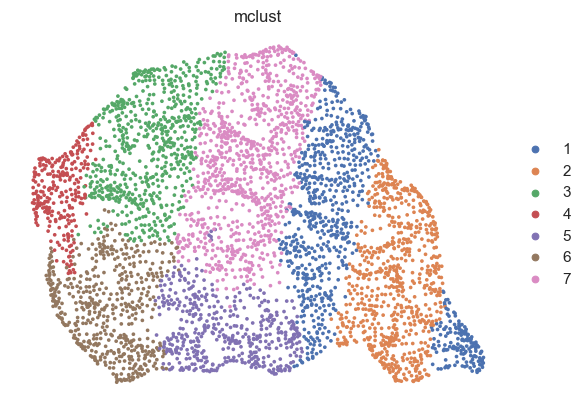

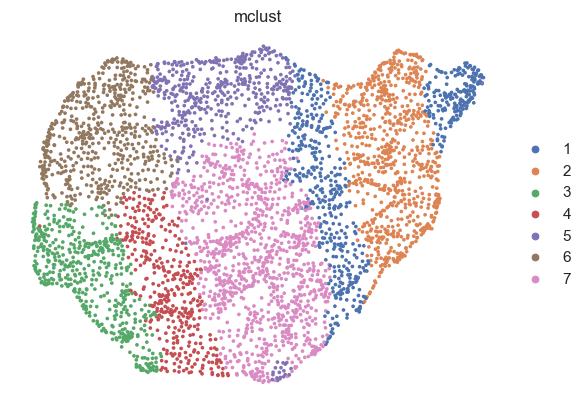

In [44]:
denoise_net = SpaUNet1DModel(in_channels=17, out_channels=1, ).to(device) # 16 time_embedding + 1 representation
niose_scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.AdamW(denoise_net.parameters(), lr=1e-4, weight_decay=1e-6)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
pbar = tqdm(range(n_epochs))
evaluate_interval = 100
logging = defaultdict(list)
n_epochs = 1000
for epoch in range(1, n_epochs+1):
    for batch_id, batch in enumerate(loader):
        clean_data = batch.x
        clean_data = clean_data.unsqueeze(1) # (batch_size, 1, num_channels)
        optimizer.zero_grad()
        noise = torch.randn_like(clean_data)
        timesteps = torch.randint(0, 1000, (clean_data.shape[0],), device=data.x.device, dtype=torch.long, )
        noisy_data = niose_scheduler.add_noise(clean_data, noise, timesteps)
        noise_pred = denoise_net(noisy_data, timesteps, batch.spatial).sample
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        logging["loss"].append(loss.item())
        # clip gradient
        torch.nn.utils.clip_grad_norm_(denoise_net.parameters(), 5)
        optimizer.step()
        lr_scheduler.step()
        pbar.set_description(f"Epoch: {epoch}, Loss: {loss.item():.4f}, batch_id: {batch_id}")
    pbar.update(1)
    if epoch % evaluate_interval == 0 or epoch == 1:
        try:
            evaluate(adata, data, niose_scheduler, denoise_net,
             save_folder="E:\Projects\diffusion\output\Single-slice-DLPFC-raw\\figures",
             prefix="{}h".format(epoch // 100), cluster_method="mclust", cluster_params=7,)
        except Exception as e:
            print(e)
torch.save(denoise_net.state_dict(), "E:\Projects\diffusion\output\Single-slice-DLPFC-raw\denoiser.pth")

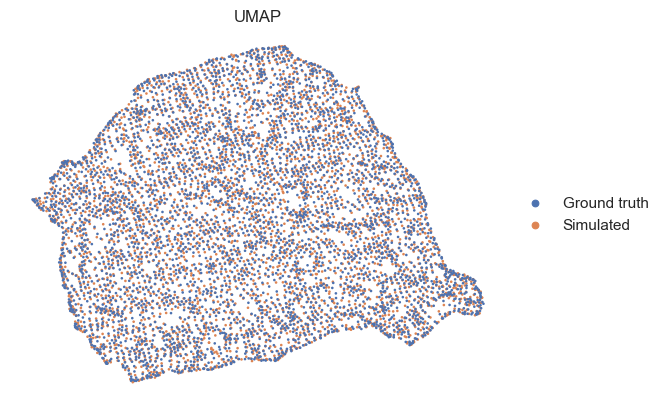

In [47]:
rep_comparison = np.concatenate([normalizer.denormalize(adata.obsm["STAGATE_denoised"]), adata.obsm["spa_ae"]], axis=0)
adata_comparison = sc.AnnData(rep_comparison)
adata_comparison.obs["type"] = ["Simulated"] * adata.shape[0] + ["Ground truth"] * adata.shape[0]
sc.pp.neighbors(adata_comparison, use_rep="X", n_neighbors=30)
sc.tl.umap(adata_comparison, min_dist=0.5)
sc.pl.umap(adata_comparison, color=["type"], title=["UMAP"], ncols=1, frameon=False, wspace=0.4, use_raw=False)

In [49]:
adata.obsm["simulated1"] = normalizer.denormalize(adata.obsm["STAGATE_denoised"])
# run mclust
adata = mclust_R(adata, 7, use_rep="spa_ae", add_key="original_mclust", random_seed=2005, modelNames="EEE")

fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


In [53]:
from stadiff.pipeline import simulate
rand_samples = simulate(data, noise_scheduler=niose_scheduler, model=denoise_net, n_samples=1,
                                 progress=True, spatial_coord=data.spatial)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [58]:
adata.obsm["simulated1"] = normalizer.denormalize(rand_samples.cpu().numpy())
adata = mclust_R(adata, 7, use_rep="simulated1", add_key="sim_mclust", random_seed=2023, modelNames="EEE")

fitting ...
  |======================================================================| 100%


Text(0.5, 1.0, 'Simulation')

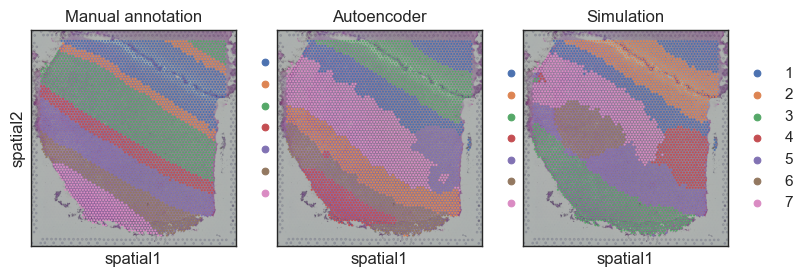

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
sc.pl.spatial(adata, color=["Manual annotation"], show=False, ax=axes[0])
sc.pl.spatial(adata, color=["original_mclust"], show=False, ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_title("Autoencoder")
sc.pl.spatial(adata, color=["sim_mclust"], show=False, ax=axes[2])
axes[2].set_ylabel("")
axes[2].set_title("Simulation")


In [64]:
marker_genes = ["ATP2B4", "RASGRF2", "LAMP5", "B3GALT2"]
def decode(model, hidden_states, edge_index):
    model.eval()
    with torch.no_grad():
        for layer in model.decoder:
            features = model._call_forward(layer, hidden_states, edge_index)
        for layer in model.out_gat:
            features = layer(features, edge_index)
    return features

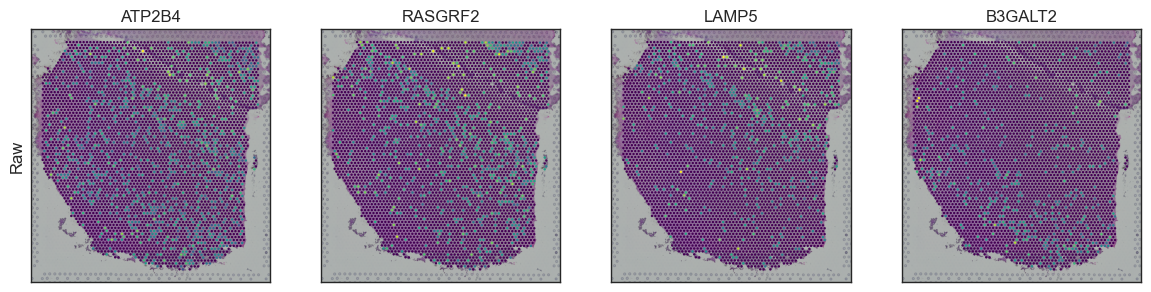

In [65]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for ind, ax in enumerate(axes):
    gene_name = marker_genes[ind]
    sc.pl.spatial(adata, color=[gene_name], frameon=True, color_map="viridis",
                  use_raw=False, ax=ax, show=False, colorbar_loc=None)
    # remove x label
    ax.set_xlabel("")
    if ind == 0:
        ax.set_ylabel("Raw")
    else:
        ax.set_ylabel("")
plt.tight_layout()

In [67]:
x = torch.from_numpy(adata.X.toarray()).to(device).float()
with torch.no_grad():
    spa_ae.eval()
    z, out = spa_ae(x, data.edge_index)
simulated = torch.from_numpy(adata.obsm["simulated1"]).to(device).float()
simulated_recon = decode(spa_ae, simulated, data.edge_index)

In [68]:
adata.obsm["simluated_recon"] = simulated_recon.cpu().numpy()
adata.obsm["true_recon"] = out.cpu().numpy()

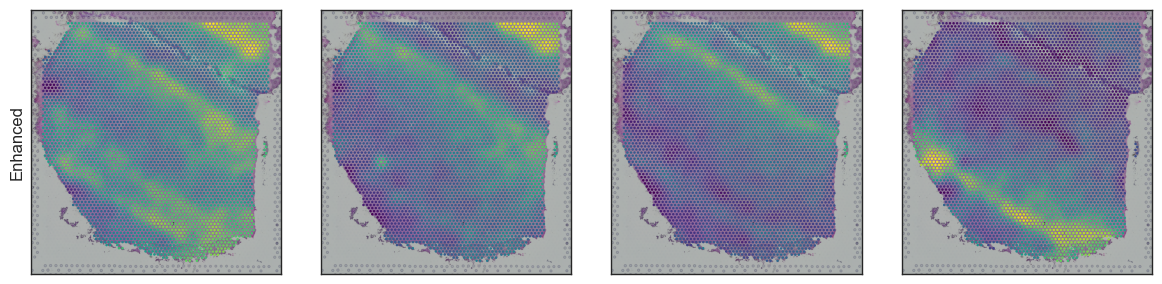

In [69]:
for ind, gene_name in enumerate(marker_genes):
    # find gene index
    gene_index = np.where(adata.var_names == gene_name)[0][0]
    adata.obs[gene_name + "_enhanced"] = adata.obsm["true_recon"][:, gene_index]
    adata.obs[gene_name + "_simulated"] = adata.obsm["simluated_recon"][:, gene_index]
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for ind, ax in enumerate(axes):
    gene_name = marker_genes[ind]
    sc.pl.spatial(adata, color=[gene_name + "_enhanced"], frameon=True, color_map="viridis",
                  use_raw=False, ax=ax, show=False, colorbar_loc=None)
    # remove x label
    ax.set_xlabel("")
    ax.set_title("")
    if ind == 0:
        ax.set_ylabel("Enhanced")
    else:
        ax.set_ylabel("")
plt.tight_layout()

In [1]:
adata

NameError: name 'adata' is not defined

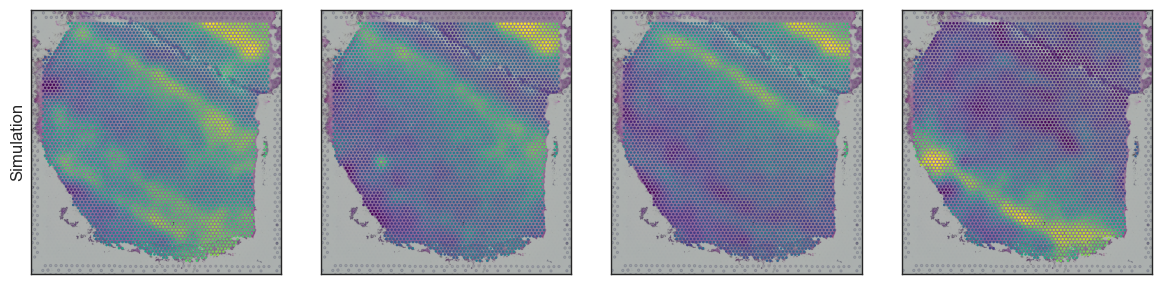

In [70]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for ind, ax in enumerate(axes):
    gene_name = marker_genes[ind]
    sc.pl.spatial(adata, color=[gene_name + "_simulated"], frameon=True, color_map="viridis",
                  use_raw=False, ax=ax, show=False, colorbar_loc=None)
    # remove x label
    ax.set_xlabel("")
    ax.set_title("")
    if ind == 0:
        ax.set_ylabel("Simulation")
    else:
        ax.set_ylabel("")
plt.tight_layout()